In [9]:
from __future__ import division
from ps4_utils import load_data,load_experiment
from ps4_utils import AbstractGenerativeModel
from ps4_utils import save_submission
from scipy.special import logsumexp
import numpy as np
data_fn = "datasets-ps4.h5"
MAX_OUTER_ITER = 15

In [18]:
class MixtureModel(AbstractGenerativeModel):
    def __init__(self, CLASSES, NUM_FEATURES, NUM_MIXTURE_COMPONENTS, MAX_ITER=50, EPS=1e-7):
        super().__init__(CLASSES, NUM_FEATURES)
        
        self.epsilon = EPS              # clamp theta in [eps, 1-eps]
        self.max_iter = MAX_ITER        # iterations of EM algo
        self.num_mixture_components = NUM_MIXTURE_COMPONENTS
        
        self.params = {}
        self.params['pi'] = [np.repeat(1/k, k) for k in self.num_mixture_components] # mixture probabilities
        self.params['theta'] = [np.zeros((self.num_features, k)) for k in self.num_mixture_components] # component probabilities
        
    def pack_params(self, X, class_idx):
        pi, theta = self.fit(X[class_idx], class_idx)
        self.params['pi'][class_idx] = pi
        self.params['theta'][class_idx] = theta
        
    def classify(self, X):
        P = list()
        pi = self.params['pi']
        theta = self.params['theta']
        for c in range(self.num_classes):
            _, Pc = self.findP(X, pi[c], theta[c])
            P.append(Pc)
        return np.vstack(P).T.argmax(-1)

    # --- E-step
    def updateLatentPosterior(self, X, pi, theta, nmm):
        logits, norm = self.findP(X, pi, theta) 
        if nmm == 1: return np.ones((len(X), 1)) # shape quirk
        return np.exp(logits - norm[:, np.newaxis])
    
    # --- M-step (1)
    @staticmethod
    def updatePi(gamma):
        return np.sum(gamma, axis=0) / len(gamma)
    
    # -- M-step (2)
    @staticmethod
    def updateTheta(X, gamma):
        return X.T @ gamma / np.sum(gamma, axis=0)
    
    @staticmethod
    def findP(X, pi, theta):
        res = np.repeat([np.log(pi)], len(X), axis=0) \
            + X @ np.log(theta) \
            + (1 - X) @ np.log(1 - theta)
        return res, logsumexp(res, axis=1)            # NxK, N
    
    @staticmethod
    def randomAssignment(X, nmm):
        theta = np.zeros((nmm, len(X[0])))
        for x in X: theta[np.random.randint(0, nmm)] += x
        return (theta / np.sum(theta, axis=1)[:, np.newaxis]).T
        
    # --- execute EM procedure
    def fit(self, X, class_idx):
        nmm = self.num_mixture_components[class_idx]
        pi = self.params['pi'][class_idx]
        theta = np.clip(self.randomAssignment(X, nmm), self.epsilon, 1 - self.epsilon)
        
        for _ in range(self.max_iter):
            gamma = self.updateLatentPosterior(X, pi, theta, nmm)
            pi = self.updatePi(gamma)
            theta = np.clip(self.updateTheta(X, gamma), self.epsilon, 1-self.epsilon)
            
        return pi, theta

In [20]:
class NaiveBayesModel(AbstractGenerativeModel):
    def __init__(self, CLASSES, NUM_FEATURES, EPS=1e-12):
        super().__init__(CLASSES, NUM_FEATURES)
        
        # for numerical stability
        self.eps = EPS
        
        # p[i][j] = p (jth feature = 1 | class i)
        self.params = {'p': [np.zeros((NUM_FEATURES))] * self.num_classes} 
        
    def pack_params(self, X, class_idx):
        self.params['p'][class_idx] = self.fit(X[class_idx])
        
    def classify(self, X):
        res = np.zeros(len(X))
        
        # each of these is CxD
        one_prob = np.log(np.array(self.params['p']) + self.eps) 
        zero_prob = np.log(1 + self.eps - np.array(self.params['p']))
        
        # this is NxC
        logits = X @ one_prob.T + (1 - X) @ zero_prob.T
        
        # take maximum along rows
        return np.argmax(logits, axis=1)
    
    def fit(self, X) -> np.ndarray:
        return np.sum(X, axis=0) / len(X)

In [49]:
experiment_name = "sentiment_analysis"
# --- SENTIMENT ANALYSIS setup
Xtrain, Xval, num_classes, num_features = load_experiment(data_fn, experiment_name)

# -- build naive bayes model for sentiment analysis
print("SENTIMENT ANALYSIS -- NAIVE BAYES MODEL:")
nbm = NaiveBayesModel(num_classes, num_features)
nbm.train(Xtrain)
print("ACCURACY ON VALIDATION: " + str(nbm.val(Xval)))

# -- build mixture model for sentiment analysis
print("SENTIMENT ANALYSIS -- MIXTURE MODEL:")
for i in range(30):
    num_mixture_components =  np.random.randint(3, 6, num_classes)
    print("COMPONENTS: " + " ".join(str(i) for i in num_mixture_components))
    mm = MixtureModel(num_classes, num_features, num_mixture_components, MAX_ITER=75, EPS=1e-7)
    mm.train(Xtrain)
    print("ACCURACY ON VALIDATION: " + str(mm.val(Xval)))

# submit to kaggle
Xkaggle = load_data(data_fn, experiment_name, "kaggle")
save_submission("mm-{}-submission.csv".format(experiment_name), mm.classify(Xkaggle))

SENTIMENT ANALYSIS -- NAIVE BAYES MODEL:
ACCURACY ON VALIDATION: 0.74
SENTIMENT ANALYSIS -- MIXTURE MODEL:
COMPONENTS: 5 4
ACCURACY ON VALIDATION: 0.722
COMPONENTS: 4 5
ACCURACY ON VALIDATION: 0.716
COMPONENTS: 3 5
ACCURACY ON VALIDATION: 0.702
COMPONENTS: 3 5
ACCURACY ON VALIDATION: 0.698
COMPONENTS: 4 3
ACCURACY ON VALIDATION: 0.738
COMPONENTS: 5 5
ACCURACY ON VALIDATION: 0.71
COMPONENTS: 5 3
ACCURACY ON VALIDATION: 0.706
COMPONENTS: 3 3
ACCURACY ON VALIDATION: 0.72
COMPONENTS: 3 5
ACCURACY ON VALIDATION: 0.736
COMPONENTS: 5 5
ACCURACY ON VALIDATION: 0.718
COMPONENTS: 3 5
ACCURACY ON VALIDATION: 0.698
COMPONENTS: 5 5
ACCURACY ON VALIDATION: 0.718
COMPONENTS: 3 4
ACCURACY ON VALIDATION: 0.696
COMPONENTS: 3 3
ACCURACY ON VALIDATION: 0.72
COMPONENTS: 3 5
ACCURACY ON VALIDATION: 0.724
COMPONENTS: 3 3
ACCURACY ON VALIDATION: 0.74
COMPONENTS: 5 3
ACCURACY ON VALIDATION: 0.716
COMPONENTS: 3 4
ACCURACY ON VALIDATION: 0.74
COMPONENTS: 3 3
ACCURACY ON VALIDATION: 0.734
COMPONENTS: 4 4
ACCURACY

In [ ]:
experiment_name = "mnist"
# --- MNIST DIGIT CLASSIFICATION setup
Xtrain, Xval, num_classes, num_features = load_experiment(data_fn, experiment_name)

# -- build naive bayes model for mnist digit classification
print("MNIST DIGIT CLASSIFICATION -- NAIVE BAYES MODEL:")
nbm = NaiveBayesModel(num_classes, num_features)
nbm.train(Xtrain)
print("ACCURACY ON VALIDATION: " + str(nbm.val(Xval)))
print()

# -- build mixture model for mnist digit classification
print("MNIST DIGIT CLASSIFICATION -- MIXTURE MODEL:")
for i in range(MAX_OUTER_ITER):
    num_mixture_components =  np.random.randint(2, 15, num_classes)
    print("COMPONENTS: " + " ".join(str(i) for i in num_mixture_components))
    mm = MixtureModel(num_classes, num_features, num_mixture_components)
    mm.train(Xtrain)
    print("ACCURACY ON VALIDATION: " + str(mm.val(Xval)))
    
# submit to kaggle
Xkaggle = load_data(data_fn, experiment_name, "kaggle")
save_submission("mm-{}-submission.csv".format(experiment_name), mm.classify(Xkaggle))

In [50]:
Xtrain, Xval, num_classes, num_features = load_experiment(data_fn, 'mnist')
nmm = np.random.randint(2, 15, num_classes)
mm = MixtureModel(num_classes, num_features, nmm)
mm.train(Xtrain)

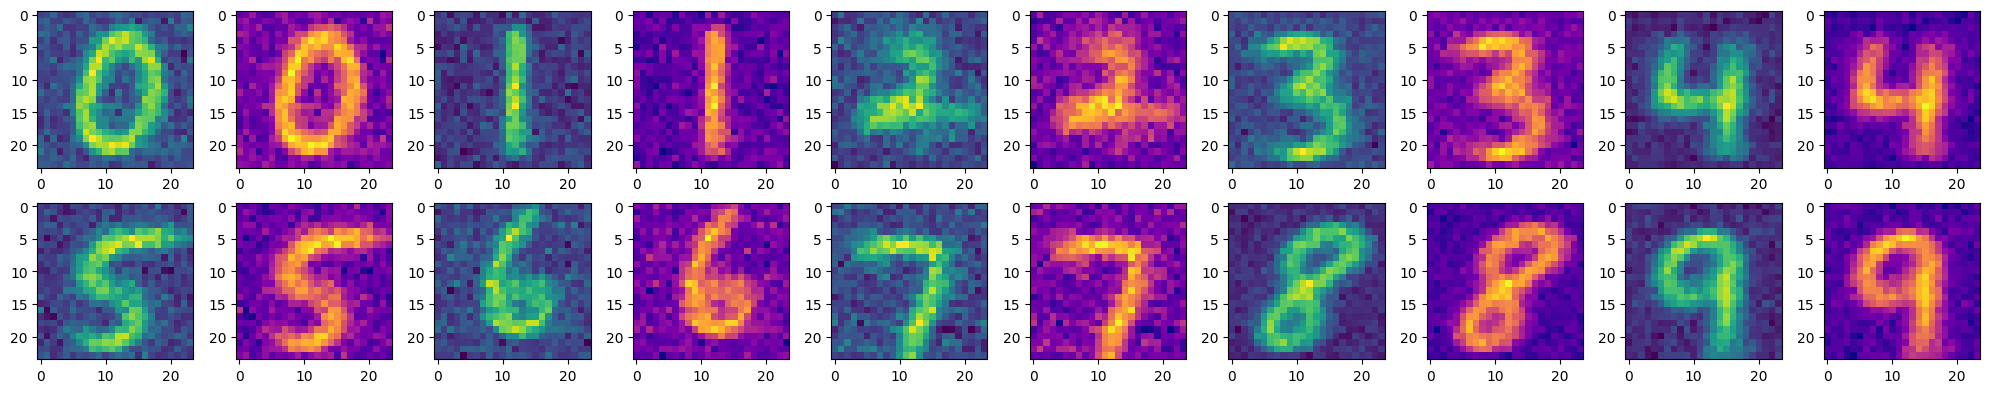

In [69]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 10, figsize=(20, 4))
axs = axs.flatten()

for i, theta in enumerate(mm.params['theta']):
    vis1 = np.array(theta)[:, 0].reshape(24, 24)
    vis2 = np.array(theta)[:, 0].reshape(24, 24)
    axs[2*i].imshow(vis1, cmap='viridis')
    axs[2*i+1].imshow(vis2, cmap='plasma')
    
plt.tight_layout()
plt.show()